### Inicialização

#### Importações

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize

In [3]:
from tqdm.notebook import tqdm

In [4]:
import time

In [5]:
import matplotlib.pyplot as plt

#### Preparacao de ambiente

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
log_filename = "Treino_GAN.txt"

In [8]:
# --- Detectar Ambiente (Colab ou Local) ---
IN_COLAB = False
try:
    # Tenta importar um módulo específico do Colab
    from google.colab import drive
    import shutil # Usaremos para copiar, se necessário, mas salvar direto é melhor
    import os

    try:
        drive.mount('/content/drive')
        # Crie um diretório específico para salvar os resultados desta execução
        save_base_dir = "/content/drive/MyDrive/GAN_Training_Results" # Ajuste o caminho como desejar
        os.makedirs(save_base_dir, exist_ok=True)
        # Opcional: Crie um subdiretório único para esta execução específica (ex: baseado em timestamp)
        # import datetime
        # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        # save_dir = os.path.join(save_base_dir, f"run_{timestamp}")
        # os.makedirs(save_dir, exist_ok=True)
        # Por simplicidade, vamos usar o diretório base diretamente por enquanto
        save_dir = save_base_dir
        print(f"✅ Google Drive montado. Arquivos serão salvos em: {save_dir}")
    except Exception as e:
        print(f"⚠️ Erro ao montar o Google Drive: {e}")
        print("   Downloads diretos serão tentados, mas podem atrasar.")
        save_dir = "." # Salvar localmente se o Drive falhar
    IN_COLAB = True
    print("✅ Ambiente Google Colab detectado. Downloads automáticos (a cada 2 épocas) ativados.")
except ImportError:
    print("✅ Ambiente local detectado. Downloads automáticos desativados.")

import os

✅ Ambiente local detectado. Downloads automáticos desativados.


#### Modelos e funcoes para ambos os metodos

##### CGAN

In [9]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)


##### F2U_GAN

In [182]:
class F2U_GAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=128):
        super(F2U_GAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        else:
            raise NotImplementedError("Only MNIST is supported")

        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        #self.label_embedding_disc = nn.Embedding(self.classes, self.img_size*self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCEWithLogitsLoss()

        # Generator (unchanged)
        self.generator = nn.Sequential(
            nn.Linear(self.latent_dim + self.label_embedding.embedding_dim, 256 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, self.channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        # Discriminator (corrected)
        self.discriminator = nn.Sequential(
        # Camada 1: 28x28 -> 14x14
        nn.utils.spectral_norm(nn.Conv2d(self.channels + self.classes, 32, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 2: 14x14 -> 7x7
        nn.utils.spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 3: 7x7 -> 3x3
        nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 4: 3x3 -> 1x1
        nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0)),  # Padding 0 aqui!
        nn.LeakyReLU(0.2, inplace=True),

        # Achata e concatena com as labels
        nn.Flatten(),
        nn.utils.spectral_norm(nn.Linear(256 * 1 * 1, 1))  # 256 (features) + embedding
        )

    def forward(self, input, labels):
        if input.dim() == 2:
            # Generator forward pass (unchanged)
            embedded_labels = self.label_embedding(labels)
            gen_input = torch.cat((input, embedded_labels), dim=1)
            x = self.generator(gen_input)
            return x.view(-1, *self.img_shape)

        elif input.dim() == 4:
            # Discriminator forward pass
            #features = self.discriminator[0:-1](input)  # Output shape: (batch, 256*1*1)
            embedded_labels = self.label_embedding(labels)
            image_labels = embedded_labels.view(embedded_labels.size(0), self.label_embedding.embedding_dim, 1, 1).expand(-1, -1, self.img_size, self.img_size)
            x = torch.cat((input, image_labels), dim=1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

##### WGAN

In [183]:
# Configurações
LATENT_DIM = 128
NUM_CHANNELS = 1
NUM_CLASSES = 10

# Camada de Convolução para o Discriminador
def conv_block(in_channels, out_channels, kernel_size=5, stride=2, padding=2, use_bn=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(NUM_CHANNELS + NUM_CLASSES, 64, use_bn=False),
            conv_block(64, 128, use_bn=True),
            conv_block(128, 256, use_bn=True),
            conv_block(256, 512, use_bn=True),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)
        )

    def forward(self, x):
        return self.model(x)

# Camada de upsample para o Gerador
def upsample_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bn=True):
    layers = [
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    return nn.Sequential(*layers)

# Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + NUM_CLASSES, 4 * 4 * 256),
            nn.BatchNorm1d(4 * 4 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 4, 4)),
            upsample_block(256, 128),
            upsample_block(128, 64),
            upsample_block(64, 32),
            nn.Conv2d(32, NUM_CHANNELS, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

 # Função de perda Wasserstein
def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

# Função para calcular Gradient Penalty
def gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolated = D(interpolated)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(d_interpolated),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

##### Modelo classificador

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##### Funcoes para geracao de dados e grafico

In [11]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import random # Needed for handling remainders if samples aren't perfectly divisible

class GeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=100,
                 num_classes=10, # Total classes the generator model knows
                 desired_classes=None, # Optional: List of specific class indices to generate
                 device="cpu",
                 image_col_name="image",
                 label_col_name="label"):
        """
        Generates a dataset using a conditional generative model, potentially
        focusing on a subset of classes.

        Args:
            generator: The pre-trained generative model.
            num_samples (int): Total number of images to generate across the desired classes.
            latent_dim (int): Dimension of the latent space vector (z).
            num_classes (int): The total number of classes the generator was trained on.
                               This is crucial for correct label conditioning (e.g., one-hot dim).
            desired_classes (list[int], optional): A list of integer class indices to generate.
                                                  If None or empty, images for all classes
                                                  (from 0 to num_classes-1) will be generated,
                                                  distributed as evenly as possible.
                                                  Defaults to None.
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
            label_col_name (str): Name for the label column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        # Store the total number of classes the generator understands
        self.total_num_classes = num_classes
        self.device = device
        self.model_type = type(self.generator).__name__ # Get generator class name
        self.image_col_name = image_col_name
        self.label_col_name = label_col_name

        # Determine the actual classes to generate based on desired_classes
        if desired_classes is not None and len(desired_classes) > 0:
            # Validate that desired classes are within the generator's known range
            if not all(0 <= c < self.total_num_classes for c in desired_classes):
                raise ValueError(f"All desired classes must be integers between 0 and {self.total_num_classes - 1}")
            # Use only the unique desired classes, sorted for consistency
            self._actual_classes_to_generate = sorted(list(set(desired_classes)))
        else:
            # If no specific classes desired, generate all classes
            self._actual_classes_to_generate = list(range(self.total_num_classes))

        # The 'classes' attribute of the dataset reflects only those generated
        self.classes = self._actual_classes_to_generate
        self.num_generated_classes = len(self.classes) # Number of classes being generated

        if self.num_generated_classes == 0 and self.num_samples > 0:
             raise ValueError("Cannot generate samples with an empty list of desired classes.")
        elif self.num_samples == 0:
             print("Warning: num_samples is 0. Dataset will be empty.")
             self.images = torch.empty(0) # Adjust shape if known
             self.labels = torch.empty(0, dtype=torch.long)
        else:
             # Generate the data only if needed
             self.images, self.labels = self.generate_data()


    def generate_data(self):
        """Generates images and corresponding labels for the specified classes."""
        self.generator.eval()
        self.generator.to(self.device)

        # --- Create Labels ---
        generated_labels_list = []
        if self.num_generated_classes > 0:
            # Distribute samples as evenly as possible among the desired classes
            samples_per_class = self.num_samples // self.num_generated_classes
            for cls in self._actual_classes_to_generate:
                generated_labels_list.extend([cls] * samples_per_class)

            # Handle remaining samples if num_samples is not perfectly divisible
            num_remaining = self.num_samples - len(generated_labels_list)
            if num_remaining > 0:
                # Add remaining samples by randomly choosing from the desired classes
                remainder_labels = random.choices(self._actual_classes_to_generate, k=num_remaining)
                generated_labels_list.extend(remainder_labels)

            # Shuffle labels for better distribution in batches later
            random.shuffle(generated_labels_list)

        # Convert labels list to tensor
        labels = torch.tensor(generated_labels_list, dtype=torch.long, device=self.device)

        # Double check label count (should match num_samples due to logic above)
        if len(labels) != self.num_samples:
             # This indicates an unexpected issue, potentially if num_generated_classes was 0 initially
             # but num_samples > 0. Raise error or adjust. Let's adjust defensively.
             print(f"Warning: Label count mismatch. Expected {self.num_samples}, got {len(labels)}. Adjusting size.")
             if len(labels) > self.num_samples:
                 labels = labels[:self.num_samples]
             else:
                 # Pad if too few (less likely with current logic unless num_generated_classes=0)
                 num_needed = self.num_samples - len(labels)
                 if self.num_generated_classes > 0:
                      padding = torch.tensor(random.choices(self._actual_classes_to_generate, k=num_needed), dtype=torch.long, device=self.device)
                      labels = torch.cat((labels, padding))
                 # If no classes to generate from, labels tensor might remain smaller

        # --- Create Latent Noise ---
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # --- Generate Images in Batches ---
        generated_images_list = []
        # Consider making batch_size configurable
        batch_size = min(1024, self.num_samples) if self.num_samples > 0 else 1

        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                labels_batch = labels[i : min(i + batch_size, self.num_samples)]

                # Skip if batch is empty (can happen if num_samples = 0)
                if z_batch.shape[0] == 0:
                    continue

                # --- Condition the generator based on its type ---
                if self.model_type == 'Generator': # Assumes input: concat(z, one_hot_label)
                    # One-hot encode labels using the TOTAL number of classes the generator knows
                    labels_one_hot_batch = F.one_hot(labels_batch, num_classes=self.total_num_classes).float()
                    generator_input = torch.cat([z_batch, labels_one_hot_batch], dim=1)
                    gen_imgs = self.generator(generator_input)
                elif self.model_type == 'CGAN' or self.model_type == "F2U_GAN": # Assumes input: z, label_index
                    gen_imgs = self.generator(z_batch, labels_batch)
                else:
                    # Handle other potential generator architectures or raise an error
                    raise NotImplementedError(f"Generation logic not defined for model type: {self.model_type}")

                generated_images_list.append(gen_imgs.cpu()) # Move generated images to CPU

        self.generator.cpu() # Move generator back to CPU after generation

        # Concatenate all generated image batches
        if generated_images_list:
            all_gen_imgs = torch.cat(generated_images_list, dim=0)
        else:
            # If no images were generated (e.g., num_samples = 0)
            # Create an empty tensor. Shape needs care - determine from generator or use placeholder.
            # Let's attempt a placeholder [0, C, H, W] - requires knowing C, H, W.
            # For now, a simple empty tensor. User might need to handle this downstream.
            print("Warning: No images generated. Returning empty tensor for images.")
            all_gen_imgs = torch.empty(0)

        return all_gen_imgs, labels.cpu() # Return images and labels (on CPU)

    def __len__(self):
        # Return the actual number of samples generated
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return {
            self.image_col_name: self.images[idx],
            self.label_col_name: int(self.labels[idx]) # Return label as standard Python int
        }


In [12]:
def generate_plot(net, device, round_number, client_id = None, examples_per_class: int=5, classes: int=10, latent_dim: int=100, server: bool=False):
    """Gera plot de imagens de cada classe"""
    if server:
        import matplotlib
        matplotlib.use("Agg")
        import matplotlib.pyplot as plt
    else:
        import matplotlib.pyplot as plt

    net_type = type(net).__name__
    net.to(device)
    net.eval()
    batch_size = examples_per_class * classes

    latent_vectors = torch.randn(batch_size, latent_dim, device=device)
    labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

    with torch.no_grad():
        if net_type == "Generator":
            labels_one_hot = torch.nn.functional.one_hot(labels, 10).float().to(device)
            generated_images = net(torch.cat([latent_vectors, labels_one_hot], dim=1))
        else:
            generated_images = net(latent_vectors, labels)

    # Criar uma figura com 10 linhas e 5 colunas de subplots
    fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

    # Adiciona título no topo da figura
    if isinstance(client_id, int):
        fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)
    else:
        fig.text(0.5, 0.98, f"Round: {round_number}", ha="center", fontsize=12)

    # Exibir as imagens nos subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, 0, :, :], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    # Ajustar o layout antes de calcular as posições
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])

    # Reduzir espaço entre colunas
    # plt.subplots_adjust(wspace=0.05)

    # Adicionar os rótulos das classes corretamente alinhados
    fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
    for row in range(classes):
        # Obter posição do subplot em coordenadas da figura
        bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
        pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
        center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

        # Adicionar o rótulo
        fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

    IN_COLAB = False
    try:
        # Tenta importar um módulo específico do Colab
        import google.colab
        IN_COLAB = True
    except:
        pass
    if IN_COLAB:
        if isinstance(client_id, int):
             fig.savefig(os.path.join(save_dir, f"mnist_{net_type}_r{round_number}_c{client_id}.png"))
        else:
            fig.savefig(os.path.join(save_dir, f"mnist_{net_type}_r{round_number}.png"))
    else:
        if isinstance(client_id, int):
            fig.savefig(f"mnist_{net_type}_r{round_number}_c{client_id}.png")
        else:
            fig.savefig(f"mnist_{net_type}_r{round_number}.png")
    plt.close(fig)
    return

In [13]:
def plot_line_graph(data_lists, y_label, x_label="Épocas", labels=None, highlight_max=False, highlight_min=False):
    """
    Gera um gráfico de linhas a partir de uma ou mais listas.

    Args:
        data_lists (list of lists): Listas contendo os valores para o eixo y.
        y_label (str): Título do eixo y.
        x_label (str): Título do eixo x. Padrão é "Épocas".
        labels (list of str): Rótulos para cada linha no gráfico. Padrão é None.
        highlight_max (bool): Se True, destaca o valor máximo no gráfico.
        highlight_min (bool): Se True, destaca o valor mínimo no gráfico.
    """
    for i, data in enumerate(data_lists):
        label = labels[i] if labels else None
        plt.plot(range(len(data)), data, label=label)

        if highlight_max:
            max_idx = data.index(max(data))
            plt.scatter(max_idx, data[max_idx], color='red', zorder=5)
            plt.text(max_idx, data[max_idx], f"Max: {data[max_idx]:.2f}", color='red', fontsize=9, ha='left', va='bottom')

        if highlight_min:
            min_idx = data.index(min(data))
            plt.scatter(min_idx, data[min_idx], color='blue', zorder=5)
            plt.text(min_idx, data[min_idx], f"Min: {data[min_idx]:.2f}", color='blue', fontsize=9, ha='left', va='top')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if labels:
        plt.legend()
    plt.grid(True)

    # Define os ticks do eixo x para mostrar apenas valores inteiros
    max_len = max(len(data) for data in data_lists)
    plt.xticks(range(0, max_len))

    plt.show()

### Federado

#### Importações

In [ ]:
if IN_COLAB:
  %pip install flwr_datasets

In [ ]:
if IN_COLAB:
  %pip install datasets

In [16]:
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner, Partitioner
from flwr_datasets import FederatedDataset
from flwr_datasets.visualization import plot_label_distributions

In [17]:
from collections import defaultdict
import random
from typing import Optional, List

In [18]:
from datasets import Dataset

#### Cria particionador por classe

In [19]:
# Copyright 2023 Flower Labs GmbH. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Class-based partitioner for Hugging Face Datasets."""

 # Assuming this is in the package structure


class ClassPartitioner(Partitioner):
    """Partitions a dataset by class, ensuring each class appears in exactly one partition.

    Attributes:
        num_partitions (int): Total number of partitions to create
        seed (int, optional): Random seed for reproducibility
        label_column (str): Name of the column containing class labels
    """

    def __init__(
        self,
        num_partitions: int,
        seed: Optional[int] = None,
        label_column: str = "label"
    ) -> None:
        super().__init__()
        self._num_partitions = num_partitions
        self._seed = seed
        self._label_column = label_column
        self._partition_indices: Optional[List[List[int]]] = None

    def _create_partitions(self) -> None:
        """Create class-based partitions and store indices."""
        # Extract labels from dataset
        labels = self.dataset[self._label_column]

        # Group indices by class
        class_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            class_indices[label].append(idx)

        classes = list(class_indices.keys())
        num_classes = len(classes)

        # Validate number of partitions
        if self._num_partitions > num_classes:
            raise ValueError(
                f"Cannot create {self._num_partitions} partitions with only {num_classes} classes. "
                f"Reduce partitions to ≤ {num_classes}."
            )

        # Shuffle classes for random distribution
        rng = random.Random(self._seed)
        rng.shuffle(classes)

        # Split classes into partitions
        partition_classes = np.array_split(classes, self._num_partitions)

        # Create index lists for each partition
        self._partition_indices = []
        for class_group in partition_classes:
            indices = []
            for cls in class_group:
                indices.extend(class_indices[cls])
            self._partition_indices.append(indices)

    @property
    def dataset(self) -> Dataset:
        return super().dataset

    @dataset.setter
    def dataset(self, value: Dataset) -> None:
        # Use parent setter for basic validation
        super(ClassPartitioner, ClassPartitioner).dataset.fset(self, value)

        # Create partitions once dataset is set
        self._create_partitions()

    def load_partition(self, partition_id: int) -> Dataset:
        """Load a partition containing exclusive classes.

        Args:
            partition_id: The ID of the partition to load (0-based index)

        Returns:
            Dataset: Subset of the dataset containing only the specified partition's data
        """
        if not self.is_dataset_assigned():
            raise RuntimeError("Dataset must be assigned before loading partitions")
        if partition_id < 0 or partition_id >= self.num_partitions:
            raise ValueError(f"Invalid partition ID: {partition_id}")

        return self.dataset.select(self._partition_indices[partition_id])

    @property
    def num_partitions(self) -> int:
        return self._num_partitions

    def __repr__(self) -> str:
        return (f"ClassPartitioner(num_partitions={self._num_partitions}, "
                f"seed={self._seed}, label_column='{self._label_column}')")

#### Carrega e prepara dados

In [55]:
num_partitions = 10
alpha_dir = 0.1

In [ ]:
partitioner = DirichletPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    alpha=alpha_dir,
    min_partition_size=0,
    self_balancing=False
)

In [32]:
partitioner = IidPartitioner(
    num_partitions=num_partitions
)

In [59]:
partitioner = ClassPartitioner(
    num_partitions=num_partitions,
    seed = 42
)

In [60]:
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": partitioner}
)

In [61]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

In [65]:
test_partition = fds.load_split("test")

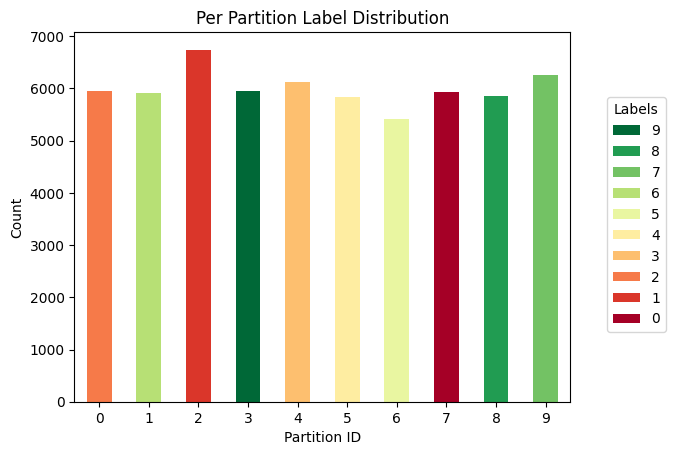

In [62]:
partitioner = fds.partitioners["train"]
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    title="Per Partition Label Distribution",
    legend=True,
    verbose_labels=True,
    size_unit="absolute",
    partition_id_axis="x",
)

Rodar proxima celula somente se quiser testar com dataset reduzido

In [37]:
num_samples = [int(len(train_partition)/10) for train_partition in train_partitions]
train_partitions = [train_partition.select(range(n)) for train_partition, n in zip(train_partitions, num_samples)]

In [63]:
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

In [64]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

c:\Users\55199\Mestrado\gerafed_env312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [66]:
test_partition = test_partition.with_transform(apply_transforms)

In [67]:
batch_size = 128
trainloaders = [DataLoader(train_partition, batch_size=batch_size, shuffle=True) for train_partition in train_partitions]

In [68]:
testloader = DataLoader(test_partition, batch_size=batch_size)

#### Inicializa modelo

CGAN

In [69]:
models = [CGAN() for i in range(num_partitions)]

F2U_GAN

In [77]:
models = [F2U_GAN() for i in range(num_partitions)]

Otimizador Disc

In [70]:
optim_Ds = [
    torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    for model in models
]

WGAN

In [57]:
discs = [Discriminator().to(device) for i in range(num_partitions)]
optim_Ds = [torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999)) for disc in discs]

gens = [Generator().to(device) for i in range(num_partitions)]
optim_Gs = [torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999)) for gen in gens]

# scheduler_Ds = [torch.optim.lr_scheduler.StepLR(optim_D, step_size=5, gamma=0.9) for optim_D in optim_Ds]

#### Treinamento

##### Importações

In [46]:
if IN_COLAB:
  !pip install flwr

In [71]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

##### CGAN/F2U_GAN

In [ ]:
rounds = 1
epochs = 200

f2u_gan = type(models[0]).__name__ == "F2U_GAN"

if f2u_gan:
    latent_dim = 128
    global_net = F2U_GAN().to(device)
else:
    latent_dim = 100
    global_net = CGAN().to(device)

gera_fig = True
net_eval = True

historico_metricas = {"accuracies": [],
                      "g_losses_e": [[] for _ in range(num_partitions)],
                      "d_losses_e": [[] for _ in range(num_partitions)],
                      "g_losses_b": [[] for _ in range(num_partitions)],
                      "d_losses_b": [[] for _ in range(num_partitions)],
                      "tempo": []}

criterion = nn.CrossEntropyLoss()

round_bar = tqdm(range(rounds), desc="Rodadas", leave=True, position=0)

for round in round_bar:
    start_time = time.time()
    print(f"\n🔸 Round {round+1}/{rounds}")

    params = []
    results = []

    client_bar = tqdm(enumerate(zip(models, trainloaders, historico_metricas["g_losses_e"], historico_metricas["d_losses_e"], historico_metricas["g_losses_b"], historico_metricas["d_losses_b"])), desc="Clientes", leave=False, position=1)

    for i, (model, trainloader, g_loss_e, d_loss_e, g_loss_b, d_loss_b) in client_bar:
        print(f"\n🔹 Client {i+1}/{num_partitions}")
        model.load_state_dict(global_net.state_dict(), strict=True)
        model.to(device) # move model to GPU if available
        model.train() # set model to training mode
        optim_G = torch.optim.Adam(model.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
        optim_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

        epoch_bar = tqdm(range(epochs), desc="Epocas locais", leave=False, position=2)

        for epoch in epoch_bar:

            print(f"\n🔹 Epoch {epoch+1}/{epochs}")

            for  batch in trainloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)

                batch_size = images.size(0)
                if batch_size == 1:
                    print(f"Batch size is 1, skipping...")
                    continue
                real_ident = torch.full((batch_size, 1), 1., device=device)
                fake_ident = torch.full((batch_size, 1), 0., device=device)

                # Train Discriminator
                optim_D.zero_grad()

                # Real images
                y_real = model(images, labels)
                d_real_loss = model.loss(y_real, real_ident)

                # Fake images
                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                x_fake = model(z_noise, x_fake_labels).detach()
                y_fake_d = model(x_fake, x_fake_labels)
                d_fake_loss = model.loss(y_fake_d, fake_ident)

                #Loss calculation
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                optim_D.step()

                # Train Generator
                optim_G.zero_grad()

                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)

                x_fake = model(z_noise, x_fake_labels)

                y_fake_g = model(x_fake, x_fake_labels)

                g_loss = model.loss(y_fake_g, real_ident)
                g_loss.backward()
                optim_G.step()

                g_loss_b.append(g_loss.item())
                d_loss_b.append(d_loss.item())

            g_loss_e.append(np.mean(g_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))
            d_loss_e.append(np.mean(d_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))


            #epoch_bar.set_postfix_str(f"Client {models.index(model)+1}/{num_partitions}")
        params.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in model.state_dict().items()]))
        results.append((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params[i], num_examples=len(trainloader.dataset), metrics={})))

    # Agrega modelos

    aggregated_ndarrays = aggregate_inplace(results)

    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    if round % 1 == 0:
        if gera_fig:
            figura = generate_plot(net=global_net, device="cpu", round_number=round+1, latent_dim=latent_dim)

        if net_eval:
            # Create the dataset and dataloader
            print("Gerando dados com o gerador global...")
            generated_dataset = GeneratedDataset(generator=global_net, num_samples=12000, latent_dim=latent_dim, num_classes=10, device="cpu")
            generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

            print("Treinando modelo classificador")
            net = Net().to(device)
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
            net.train()
            for epoch in range(5):
                for data in generated_dataloader:
                    inputs, labels = data["image"].to(device), data["label"].to(device)
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            correct, loss = 0, 0.0
            net.eval()
            with torch.no_grad():
                for batch in testloader:
                    images = batch["image"].to(device)
                    labels = batch["label"].to(device)
                    outputs = net(images)
                    loss += criterion(outputs, labels).item()
                    correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            accuracy = correct / len(testloader.dataset)
            print(f"Acuracia: {accuracy:.4f}")

            historico_metricas["accuracies"].append(accuracy)


            # with open(log_filename, "a") as f:
            #       f.write(f"Epoca: {epoch+1}, D_loss: {avg_epoch_D_loss:.4f}, G_loss: {avg_epoch_G_loss:.4f}, Acc: {accuracy:.4f}, Tempo: {total_time:.4f}\n")

            #Atualiza o learning_rate
            # scheduler_G.step()
            # scheduler_D.step()
            # print(f"Após Epoch {epoch+1}, LR_G: {optim_G.param_groups[0]['lr']:.6f}, LR_D: {optim_D.param_groups[0]['lr']:.6f}")

            model_filename = f"{type(global_net).__name__}_{round+1}r.pth"
            if IN_COLAB:
                model_filename = os.path.join(save_dir, model_filename)
            torch.save(global_net.state_dict(), model_filename)

print("✅ Treinamento Concluído!")

##### WGAN

In [58]:
rounds = 4
epochs = 10

wgan = True
latent_dim = 128
global_disc = Discriminator().to(device)
global_gen = Generator().to(device)
gp_scale = 10
gera_fig = True
net_eval = True

historico_metricas = {"accuracies": [],
                      "g_losses_e": [[] for _ in range(num_partitions)],
                      "d_losses_e": [[] for _ in range(num_partitions)],
                      "g_losses_b": [[] for _ in range(num_partitions)],
                      "d_losses_b": [[] for _ in range(num_partitions)],
                      "accuracies": []}

criterion = nn.CrossEntropyLoss()

round_bar = tqdm(range(rounds), desc="Rodadas", leave=True, position=0)

for round in round_bar:

    print(f"\n🔸 Round {round+1}/{rounds}")

    params = []
    results = []
    params_gen = []
    results_gen = []


    client_bar = tqdm(enumerate(zip(discs, gens, trainloaders, historico_metricas["g_losses_e"], historico_metricas["d_losses_e"], historico_metricas["g_losses_b"], historico_metricas["d_losses_b"])), desc="Clientes", leave=False, position=1)

    for i, (disc, gen, trainloader, g_loss_e, d_loss_e, g_loss_b, d_loss_b) in client_bar:
        print(f"\n🔹 Client {i+1}/{num_partitions}")
        disc.load_state_dict(global_disc.state_dict(), strict=True)
        disc.to(device) # move model to GPU if available
        disc.train() # set model to training mode
        optim_D = optim_Ds[i]

        gen.load_state_dict(global_gen.state_dict(), strict=True)
        gen.to(device) # move model to GPU if available
        gen.train() # set model to training mode
        optim_G = optim_Gs[i]

        epoch_bar = tqdm(range(epochs), desc="Epocas locais", leave=False, position=2)

        for epoch in epoch_bar:

            print(f"\n🔹 Epoch {epoch+1}/{epochs}")

            for  batch in trainloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)

                batch_size = images.size(0)
                if batch_size == 1:
                    print(f"Batch size is 1, skipping...")
                    continue

                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                z_noise = torch.randn(batch_size, latent_dim, device=device)

                # Train Discriminator
                optim_D.zero_grad()

                labels = torch.nn.functional.one_hot(labels, 10).float().to(device)
                fake_labels = torch.nn.functional.one_hot(x_fake_labels, 10).float()

                # Adicionar labels ao real_images para treinamento do Discriminador
                image_labels = labels.view(labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
                image_fake_labels = fake_labels.view(fake_labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)

                real_images = torch.cat([images, image_labels], dim=1)

                # Treinar Discriminador
                z = torch.cat([z_noise, fake_labels], dim=1)
                fake_images = gen(z).detach()
                fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

                d_loss = discriminator_loss(disc(real_images), disc(fake_images)) + gp_scale * gradient_penalty(disc, real_images, fake_images)

                d_loss.backward()
                optim_D.step()

                # Train Generator
                optim_G.zero_grad()

                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                fake_labels = torch.nn.functional.one_hot(x_fake_labels, 10).float()

                z = torch.cat([z_noise, fake_labels], dim=1)

                x_fake = gen(z)

                image_fake_labels = fake_labels.view(fake_labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)

                x_fake = torch.cat([x_fake, image_fake_labels], dim=1)

                y_fake_g = disc(x_fake)

                g_loss = generator_loss(y_fake_g)

                g_loss.backward()
                optim_G.step()

                g_loss_b.append(g_loss.item())
                d_loss_b.append(d_loss.item())

            g_loss_e.append(np.mean(g_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))
            d_loss_e.append(np.mean(d_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))


            #epoch_bar.set_postfix_str(f"Client {models.index(model)+1}/{num_partitions}")
        params.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in disc.state_dict().items()]))
        results.append((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params[i], num_examples=len(trainloader.dataset), metrics={})))

        params_gen.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in gen.state_dict().items()]))
        results_gen.append((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params_gen[i], num_examples=len(trainloader.dataset), metrics={})))
    # Agrega modelos

    aggregated_ndarrays = aggregate_inplace(results)
    params_dict = zip(global_disc.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_disc.load_state_dict(state_dict, strict=True)

    aggregated_ndarrays_gen = aggregate_inplace(results_gen)
    params_dict_gen = zip(global_gen.state_dict().keys(), aggregated_ndarrays_gen)
    state_dict_gen = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict_gen})
    global_gen.load_state_dict(state_dict_gen, strict=True)

    if gera_fig:
        figura = generate_plot(net=global_gen, device="cpu", round_number=round + 1, latent_dim=latent_dim)

    if net_eval:
        # Create the dataset and dataloader
        print("Gerando dados com o gerador global...")
        generated_dataset = GeneratedDataset(generator=global_gen, num_samples=12000, latent_dim=latent_dim, num_classes=10, device="cpu")
        generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

        print("Treinando modelo classificador")
        net = Net().to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        net.train()
        for epoch in range(5):
            for data in generated_dataloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        correct, loss = 0, 0.0
        net.eval()
        with torch.no_grad():
            for batch in testloader:
                images = batch["image"].to(device)
                labels = batch["label"].to(device)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)
        print(f"Acuracia: {accuracy:.4f}")

        historico_metricas["accuracies"].append(accuracy)

        # with open(log_filename, "a") as f:
        #       f.write(f"Epoca: {epoch+1}, D_loss: {avg_epoch_D_loss:.4f}, G_loss: {avg_epoch_G_loss:.4f}, Acc: {accuracy:.4f}, Tempo: {total_time:.4f}\n")

        #Atualiza o learning_rate
        # scheduler_G.step()
        # scheduler_D.step()
        # print(f"Após Epoch {epoch+1}, LR_G: {optim_G.param_groups[0]['lr']:.6f}, LR_D: {optim_D.param_groups[0]['lr']:.6f}")

    model_filename = f"{type(global_gen).__name__}_{round+1}r.pth"
    if IN_COLAB:
        model_filename = os.path.join(save_dir, model_filename)
    torch.save({"generator": global_gen.state_dict(), "discriminator": global_disc.state_dict()}, model_filename)

Rodadas:   0%|          | 0/4 [00:00<?, ?it/s]


🔸 Round 1/4


Clientes: 0it [00:00, ?it/s]


🔹 Client 1/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 2/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 3/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 4/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10
Gerando dados com o gerador global...
Treinando modelo classificador
Acuracia: 0.8882

🔸 Round 2/4


Clientes: 0it [00:00, ?it/s]


🔹 Client 1/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 2/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 3/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 4/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10
Gerando dados com o gerador global...
Treinando modelo classificador
Acuracia: 0.9364

🔸 Round 3/4


Clientes: 0it [00:00, ?it/s]


🔹 Client 1/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 2/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 3/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 4/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10
Gerando dados com o gerador global...
Treinando modelo classificador
Acuracia: 0.9414

🔸 Round 4/4


Clientes: 0it [00:00, ?it/s]


🔹 Client 1/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 2/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 3/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10

🔹 Client 4/4


Epocas locais:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Epoch 1/10

🔹 Epoch 2/10

🔹 Epoch 3/10

🔹 Epoch 4/10

🔹 Epoch 5/10

🔹 Epoch 6/10

🔹 Epoch 7/10

🔹 Epoch 8/10

🔹 Epoch 9/10

🔹 Epoch 10/10
Gerando dados com o gerador global...
Treinando modelo classificador
Acuracia: 0.9319


#### Plot

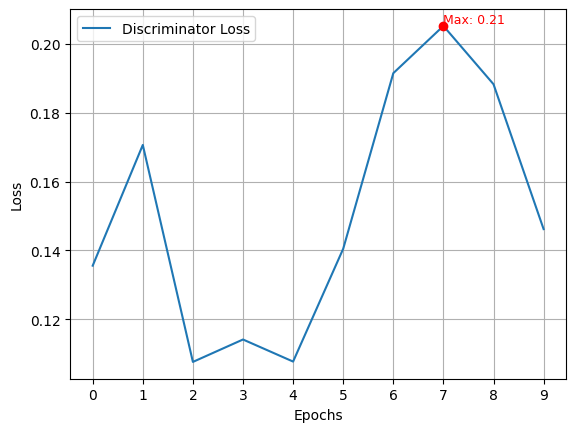

In [81]:
# Plot the discriminator and generator loss per batch
plot_line_graph(
    data_lists=[historico_metricas["accuracies"]],
    y_label="Loss",
    x_label="Epochs",
    labels=["Discriminator Loss"],
    highlight_max=True,
)

### Centralizado

##### Carrega e prepara dados

In [68]:
BATCH_SIZE = 128

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

#### Inicializa modelos

CGAN

In [ ]:
model = CGAN().to(device)

F2U_GAN

In [ ]:
model = F2U_GAN().to(device)

Otimizadores

In [ ]:
optim_G = torch.optim.Adam(model.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

WGAN

In [18]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.9

# Inicializar modelos
D = Discriminator().to(device)
G = Generator(latent_dim=LATENT_DIM).to(device)
# Otimizadores
optim_D = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optim_G = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

#scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.9)
#scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.9)

#### Treinamento

In [ ]:
# Treinamento
NUM_CLASSES = 10
GP_SCALE = 10
EPOCHS = 20
historico_metricas = {"d_loss_b": [],
                      "g_loss_b": [],
                      "d_loss_e": [],
                      "g_loss_e": [],
                      "accuracy": [],
                      "time": []}

wgan = True
try:
    f2u_gan = type(model).__name__ == "F2U_CGAN" or type(model).__name__ == "F2U_GAN"
    conditional = type(model).__name__ == "CGAN" or type(model).__name__ == "F2U_CGAN"
except:
    f2u_cgan = False

if wgan:
    LATENT_DIM = 128
    G.to(device)
elif f2u_gan:
    LATENT_DIM = 128
    model.to(device)
else:
    LATENT_DIM = 100
    model.to(device)

gera_fig = True
net_eval = True

epoch_bar = tqdm(range(EPOCHS), desc="Treinamento", leave=True, position=0)

for epoch in epoch_bar:

    print(f"\n🔹 Epoch {epoch+1}/{EPOCHS}")
    G_loss = 0
    D_loss = 0
    batches = 0

    batch_bar = tqdm(trainloader, desc="Batches", leave=False, position=1)

    start_time = time.time()
    for real_images, labels in batch_bar:
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch = real_images.size(0)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch,), device=device)
        z = torch.randn(batch, LATENT_DIM).to(device)
        optim_D.zero_grad()
        if wgan:
            labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)
            fake_labels = torch.nn.functional.one_hot(fake_labels, NUM_CLASSES).float()

            # Adicionar labels ao real_images para treinamento do Discriminador
            image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)
            image_fake_labels = fake_labels.view(fake_labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)

            real_images = torch.cat([real_images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.cat([z, fake_labels], dim=1)
            fake_images = G(z).detach()
            fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

            loss_D = discriminator_loss(D(real_images), D(fake_images)) + GP_SCALE * gradient_penalty(D, real_images, fake_images)

        else:
            real_ident = torch.full((batch, 1), 1., device=device)
            fake_ident = torch.full((batch, 1), 0., device=device)
            x_fake = model(z, fake_labels)

            y_real = model(real_images, labels)
            d_real_loss = model.loss(y_real, real_ident)
            y_fake_d = model(x_fake.detach(), fake_labels)
            d_fake_loss = model.loss(y_fake_d, fake_ident)
            loss_D = (d_real_loss + d_fake_loss) / 2

        loss_D.backward()
        optim_D.step()

        optim_G.zero_grad()

        # z = torch.randn(batch, LATENT_DIM).to(device)
        # z = torch.cat([z, fake_labels], dim=1)
        if wgan:
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_fake_labels], dim=1)))
        else:
            y_fake_g = model(x_fake, fake_labels)
            loss_G = model.loss(y_fake_g, real_ident)

        loss_G.backward()
        optim_G.step()

        G_loss += loss_G.item()
        D_loss += loss_D.item()
        historico_metricas["d_loss_b"].append(loss_D.item())
        historico_metricas["g_loss_b"].append(loss_G.item())
        batches += 1

    avg_epoch_G_loss = G_loss/batches
    avg_epoch_D_loss = D_loss/batches
    historico_metricas["d_loss_e"].append(avg_epoch_D_loss)
    historico_metricas["g_loss_e"].append(avg_epoch_G_loss)

    if gera_fig:
        # Gera plot de imagens de cada classe
        if wgan:
            figura = generate_plot(net=G, device="cpu", round_number=epoch+1, latent_dim=LATENT_DIM)
        else:
            figura = generate_plot(net=model, device="cpu", round_number=epoch+1, latent_dim=LATENT_DIM)
    if net_eval:
        # Create the dataset and dataloader
        if wgan:
            generated_dataset = GeneratedDataset(generator=G, num_samples=10000, latent_dim=LATENT_DIM, num_classes=10, device="cpu")
            G.to(device)
        else:
            generated_dataset = GeneratedDataset(generator=model, num_samples=10000, latent_dim=LATENT_DIM, num_classes=10, device="cpu")
            model.to(device)

        generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

        net = Net()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        net.train()
        for _ in range(5):
            for data in generated_dataloader:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        net.eval()
        correct, loss = 0, 0.0
        with torch.no_grad():
            for batch in testloader:
                images = batch[0]
                labels = batch[1]
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)

        end_time = time.time()
        total_time = end_time - start_time

        epoch_bar.set_postfix({
            "D_loss": f"{avg_epoch_D_loss:.4f}",
            "G_loss": f"{avg_epoch_G_loss:.4f}",
            "Acc": f"{accuracy:.4f}"
        })
        if IN_COLAB:
            log_filename = os.path.join(save_dir, f"Treino_GAN.txt")
        with open(log_filename, "a") as f:
                f.write(f"Epoca: {epoch+1}, D_loss: {avg_epoch_D_loss:.4f}, G_loss: {avg_epoch_G_loss:.4f}, Acc: {accuracy:.4f}, Tempo: {total_time:.4f}\n")

        historico_metricas["accuracy"].append(accuracy)
        historico_metricas["time"].append(total_time)

    #Atualiza o learning_rate
    # scheduler_G.step()
    # scheduler_D.step()
    # print(f"Após Epoch {epoch+1}, LR_G: {optim_G.param_groups[0]['lr']:.6f}, LR_D: {optim_D.param_groups[0]['lr']:.6f}")
    if wgan:
        # Salvar modelo a cada época
        model_filename = f"wgan_{epoch+1}e.pth"
        if IN_COLAB:
            model_filename = os.path.join(save_dir, model_filename)
        torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, model_filename)
    else:
        model_filename = f"{type(model).__name__}_{epoch+1}_e.pth"
        if IN_COLAB:
            model_filename = os.path.join(save_dir, model_filename)
        torch.save(model.state_dict(), model_filename)

print("✅ Treinamento Concluído!")

#### Plot

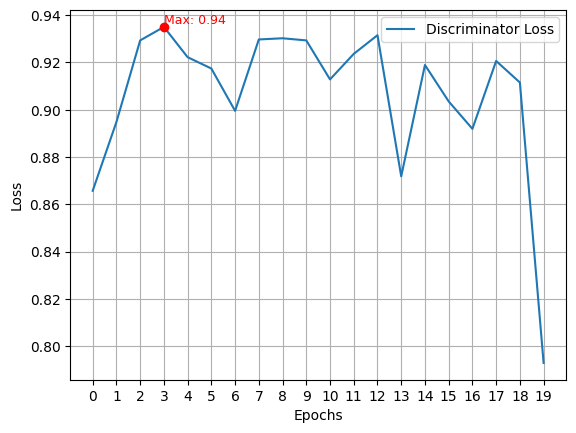

In [23]:
# Plot the discriminator and generator loss per batch
plot_line_graph(
    data_lists=[historico_metricas["accuracy"]],
    y_label="Loss",
    x_label="Epochs",
    labels=["Discriminator Loss", "Generator Loss"],
    highlight_max=True,
)

### Area de testes

#### LoRa

In [72]:
class LoRALinear(nn.Module):
    def __init__(self, orig_linear: nn.Linear, r: int = 8, alpha: float = 16):
        super().__init__()

        self.orig_linear = orig_linear
        self.r = r
        self.alpha = alpha
        # Criando os Adapters: A (out_features x r) and B (r x in_features), onde r será o rank intermediário
        self.lora_A = nn.Parameter(torch.zeros(orig_linear.out_features, r))
        self.lora_B = nn.Parameter(torch.zeros(r, orig_linear.in_features))
        # Inicializando: usando Kaiming-uniform para a matriz A e zeros para a matriz B. Dessa forma, no inicio não ocorre mudanças no modelo.
        #nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        #with normal
        nn.init.normal_(self.lora_A)
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        # Compute original output plus LoRA adjustment.
        # F.linear computes x @ weight.T + bias.
        lora_update = F.linear(x, self.lora_A @ self.lora_B)
        return self.orig_linear(x) + self.alpha * lora_update

In [73]:
def add_lora_to_model(model: nn.Module, r: int = 8, alpha: float = 16, target_module_names=None):

    if target_module_names is None: #Colocaremos adapters apenas nas camadas com esses nome.
        target_module_names = ['q_proj', 'k_proj', 'v_proj']

    for name, module in model.named_children():
        # Recursively process children modules.
        add_lora_to_model(module, r, alpha, target_module_names)

        # Troca apara a camada do LoRA quando o nome da camada é igual a algum dos target_module_names
        if isinstance(module, nn.Linear):
            setattr(model, name, LoRALinear(module, r=r, alpha=alpha))

    return model

In [74]:
for model in models:
    model.load_state_dict(torch.load("gen_round100.pt"))
    model = add_lora_to_model(model, r=8, alpha=16)

In [75]:
def prepare_model_for_lora(model):

    for param in model.parameters():
        param.requires_grad = False

    for module in model.modules():
        if isinstance(module, LoRALinear):
            module.lora_A.requires_grad = True
            module.lora_B.requires_grad = True

In [76]:
for model in models:
    prepare_model_for_lora(model)

In [77]:
epochs = 50
log_filename_lora = "Treino_GAN_LoRA.txt"

f2u_gan = type(models[0]).__name__ == "F2U_GAN"

if f2u_gan:
    latent_dim = 128
else:
    latent_dim = 100

gera_fig = True
net_eval = False

historico_metricas = {"g_losses_e": [[] for _ in range(num_partitions)],
                      "d_losses_e": [[] for _ in range(num_partitions)],
                      "g_losses_b": [[] for _ in range(num_partitions)],
                      "d_losses_b": [[] for _ in range(num_partitions)],
                      "tempo": []}

#criterion = nn.CrossEntropyLoss()

#round_bar = tqdm(range(rounds), desc="Rodadas", leave=True, position=0)

client_bar = tqdm(enumerate(zip(models, trainloaders, historico_metricas["g_losses_e"], historico_metricas["d_losses_e"], historico_metricas["g_losses_b"], historico_metricas["d_losses_b"])), desc="Clientes", leave=True, position=0)

for i, (model, trainloader, g_loss_e, d_loss_e, g_loss_b, d_loss_b) in client_bar:
    print(f"\n🔹 Client {i+1}/{num_partitions}")
    model.to(device) # move model to GPU if available
    model.train() # set model to training mode
    optim_G = torch.optim.Adam(model.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optim_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    epoch_bar = tqdm(range(epochs), desc="Epocas locais", leave=False, position=1)

    for epoch in epoch_bar:
        start_time = time.time()

        print(f"\n🔹 Epoch {epoch+1}/{epochs}")

        for  batch in trainloader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            batch_size = images.size(0)
            if batch_size == 1:
                print(f"Batch size is 1, skipping...")
                continue
            real_ident = torch.full((batch_size, 1), 1., device=device)
            fake_ident = torch.full((batch_size, 1), 0., device=device)

            # Train Discriminator
            optim_D.zero_grad()

            # Real images
            y_real = model(images, labels)
            d_real_loss = model.loss(y_real, real_ident)

            # Fake images
            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
            x_fake = model(z_noise, x_fake_labels).detach()
            y_fake_d = model(x_fake, x_fake_labels)
            d_fake_loss = model.loss(y_fake_d, fake_ident)

            #Loss calculation
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optim_D.step()

            # Train Generator
            optim_G.zero_grad()

            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)

            x_fake = model(z_noise, x_fake_labels)

            y_fake_g = model(x_fake, x_fake_labels)

            g_loss = model.loss(y_fake_g, real_ident)
            g_loss.backward()
            optim_G.step()

            g_loss_b.append(g_loss.item())
            d_loss_b.append(d_loss.item())

        g_loss_e.append(np.mean(g_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))
        d_loss_e.append(np.mean(d_loss_b[epoch*len(trainloader):(epoch+1)*len(trainloader)]))


        if gera_fig and (epoch+1) % 5 == 0:
            figura = generate_plot(net=model, device="cpu", round_number=epoch+1, latent_dim=latent_dim, client_id=i+1)
            model.to(device)
            model_filename = f"{type(model).__name__}_{epoch+1}e_c{i+1}.pth"
            if IN_COLAB:
                model_filename = os.path.join(save_dir, model_filename)
            torch.save(model.state_dict(), model_filename)

        end_time = time.time()

        total_time = end_time - start_time
        historico_metricas["tempo"].append(total_time)

        if IN_COLAB:
            log_filename_lora = os.path.join(save_dir,log_filename_lora)
        with open(log_filename_lora, "a") as f:
                f.write(f"Cliente {i+1}: Epoca: {epoch+1}, D_loss: {d_loss_e[-1]:.4f}, G_loss: {g_loss_e[-1]:.4f}, Tempo: {total_time:.4f}\n")

print("✅ Treinamento Concluído!")

Clientes: 0it [00:00, ?it/s]


🔹 Client 1/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 2/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 3/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 4/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 5/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 6/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 7/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 8/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50

🔹 Epoch 23/50

🔹 Epoch 24/50

🔹 Epoch 25/50

🔹 Epoch 26/50

🔹 Epoch 27/50

🔹 Epoch 28/50

🔹 Epoch 29/50

🔹 Epoch 30/50

🔹 Epoch 31/50

🔹 Epoch 32/50

🔹 Epoch 33/50

🔹 Epoch 34/50

🔹 Epoch 35/50

🔹 Epoch 36/50

🔹 Epoch 37/50

🔹 Epoch 38/50

🔹 Epoch 39/50

🔹 Epoch 40/50

🔹 Epoch 41/50

🔹 Epoch 42/50

🔹 Epoch 43/50

🔹 Epoch 44/50

🔹 Epoch 45/50

🔹 Epoch 46/50

🔹 Epoch 47/50

🔹 Epoch 48/50

🔹 Epoch 49/50

🔹 Epoch 50/50

🔹 Client 9/10


Epocas locais:   0%|          | 0/50 [00:00<?, ?it/s]


🔹 Epoch 1/50

🔹 Epoch 2/50

🔹 Epoch 3/50

🔹 Epoch 4/50

🔹 Epoch 5/50

🔹 Epoch 6/50

🔹 Epoch 7/50

🔹 Epoch 8/50

🔹 Epoch 9/50

🔹 Epoch 10/50

🔹 Epoch 11/50

🔹 Epoch 12/50

🔹 Epoch 13/50

🔹 Epoch 14/50

🔹 Epoch 15/50

🔹 Epoch 16/50

🔹 Epoch 17/50

🔹 Epoch 18/50

🔹 Epoch 19/50

🔹 Epoch 20/50

🔹 Epoch 21/50

🔹 Epoch 22/50


KeyboardInterrupt: 

#### Acurácia por classe

In [70]:
# Parameters
num_samples = 1200
latent_dim = 100

model2 = CGAN().to("cpu")
add_lora_to_model(model2, r=8, alpha=16)
model2.load_state_dict(torch.load("CGAN_35e_c2.pth", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset2 = GeneratedDataset(generator=model2, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu", desired_classes=[3,4,9])

In [71]:
print(f"\nDataset with subset classes: {len(generated_dataset2)} samples.")
print(f"Classes present: {generated_dataset2.classes}") # Should be [3, 5, 8]
print(f"Label counts: {torch.unique(generated_dataset2.labels, return_counts=True)}")


Dataset with subset classes: 1200 samples.
Classes present: [3, 4, 9]
Label counts: (tensor([3, 4, 9]), tensor([400, 400, 400]))


In [76]:
generated_dataset = torch.utils.data.ConcatDataset([generated_dataset2, train_partitions[0]])

In [77]:
generated_dataloader = DataLoader(generated_dataset, batch_size=128, shuffle=True)

In [17]:
# Parameters
num_samples = 12000
latent_dim = 100

model2 = CGAN().to("cpu")
add_lora_to_model(model2, r=8, alpha=16)
model2.load_state_dict(torch.load("CGAN_35e_c2.pth", map_location=torch.device('cpu')))

model3 = CGAN().to("cpu")
add_lora_to_model(model3, r=8, alpha=16)
model3.load_state_dict(torch.load("CGAN_35e_c3.pth", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset2 = GeneratedDataset(generator=model2, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataset3 = GeneratedDataset(generator=model3, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")

generated_dataset = torch.utils.data.ConcatDataset([generated_dataset2, generated_dataset3])

generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

In [78]:
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in range(5):
    for data in generated_dataloader:
        inputs, labels = data["image"], data["label"]
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [79]:
from collections import defaultdict

# Initialize counters
num_classes = 10  # Update with your actual number of classes
class_correct = defaultdict(int)
class_total = defaultdict(int)
predictions_counter = defaultdict(int)

# Evaluation
net.eval()
with torch.no_grad():
    for batch in testloader:
        images, labels = batch[0], batch[1]
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        # Update counts for each sample in batch
        for true_label, pred_label in zip(labels, predicted):
            true_idx = true_label.item()
            pred_idx = pred_label.item()
            
            class_total[true_idx] += 1
            predictions_counter[pred_idx] += 1
            
            if true_idx == pred_idx:
                class_correct[true_idx] += 1

# Create results dictionary
results = {
    "class_metrics": {},
    "overall_accuracy": None,
    "prediction_distribution": dict(predictions_counter)
}

# Calculate class-wise metrics
for i in range(num_classes):
    metrics = {
        "samples": class_total[i],
        "predictions": predictions_counter[i],
        "accuracy": class_correct[i] / class_total[i] if class_total[i] > 0 else "N/A"
    }
    results["class_metrics"][f"class_{i}"] = metrics

# Calculate overall accuracy
total_samples = sum(class_total.values())
results["overall_accuracy"] = sum(class_correct.values()) / total_samples

# Save to txt file
with open("accuracy_report.txt", "w") as f:
    # Header with fixed widths
    f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
        "Class", "Accuracy", "Samples", "Predictions"))
    f.write("-"*45 + "\n")
    
    # Class rows with consistent formatting
    for cls in range(num_classes):
        metrics = results["class_metrics"][f"class_{cls}"]
        
        # Format accuracy (handle "N/A" case)
        accuracy = (f"{metrics['accuracy']:.4f}" 
                   if isinstance(metrics['accuracy'], float) 
                   else "  N/A  ")
        
        f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
            f"Class {cls}",
            accuracy,
            metrics['samples'],
            metrics['predictions']
        ))
    
    # Footer with alignment
    f.write("\n{:<20} {:.4f}".format("Overall Accuracy:", results["overall_accuracy"]))
    f.write("\n{:<20} {}".format("Total Samples:", total_samples))
    f.write("\n{:<20} {}".format("Total Predictions:", sum(predictions_counter.values())))

print("Results saved to accuracy_report.txt")

Results saved to accuracy_report.txt


#### Testes lora no gerafed

In [25]:
def get_lora_adapters(model):
    lora_params = []
    for module in model.modules():
        if isinstance(module, LoRALinear):
            lora_params.append((module.lora_A, module.lora_B))
    return lora_params

def set_lora_adapters(model, lora_params):
    for module in model.modules():
        if isinstance(module, LoRALinear):
            module.lora_A, module.lora_B = lora_params.pop(0)
    return model

In [83]:
for model in models:
    add_lora_to_model(model, r=8, alpha=16)

In [26]:
loras_tuples = [get_lora_adapters(model) for model in models]

In [201]:
len(loras_tuples[0])

10

In [27]:
import torch
from torch.nn.parameter import Parameter
import numpy as np # Import numpy for type hinting if desired

def get_lora_weights_from_list(lora_params_list: list[tuple[Parameter, Parameter]]) -> list[np.ndarray]:
    """
    Extracts LoRA parameters (A and B matrices) from a list of tuples
    into a single flat list of NumPy arrays.

    Args:
        lora_params_list: A list where each element is a tuple containing
                          two torch.nn.parameter.Parameter objects
                          (representing LoRA A and B matrices).

    Returns:
        A list of NumPy arrays containing the data from all parameters.
    """
    weights_list = []
    for lora_tuple in lora_params_list:
        # Process both parameters (A and B matrices) in the tuple
        for param in lora_tuple:
            # Detach from graph, move to CPU, convert to NumPy
            weights_list.append(param.detach().cpu().numpy())
    return weights_list


In [28]:
loras_arrays = [get_lora_weights_from_list(lora) for lora in loras_tuples]

In [202]:
len(loras_arrays[0])

20

In [29]:
from flwr.common import (
    Config,
    NDArrays,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

In [ ]:
def get_weights(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [168]:
gen_params_arrays = [get_weights(model) for model in models]

In [169]:
gen_param_parameters = [ndarrays_to_parameters(param) for param in gen_params_arrays]

In [30]:
lora_parameters = [ndarrays_to_parameters(lora) for lora in loras_arrays]

In [170]:
from flwr.common import FitRes, Status, Code
results= [((i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=gen_param_parameters[i], num_examples=1, metrics={}))) for i in range(len(gen_param_parameters))]

In [172]:
from flwr.server.strategy.aggregate import aggregate_inplace
aggregated_gen_ndarrays = aggregate_inplace(results)

In [173]:
aggregated_gen_parameters = ndarrays_to_parameters(aggregated_gen_ndarrays)

In [33]:
import pickle

In [40]:
classes_lora = [pickle.dumps(sorted(set(trainloader.dataset["label"]))) for trainloader in trainloaders]

In [41]:
lora_dict = {}
for i, (lora, classes) in enumerate(zip(lora_parameters, classes_lora)):
    lora_dict[i] = (i, (classes, lora))
    print(len(lora_dict[i][1][1].tensors))
    print(lora_dict[i][0])
    print(lora_dict[i][1][0])

20
0
b'\x80\x04\x95\x06\x00\x00\x00\x00\x00\x00\x00]\x94K\x02a.'
20
1
b'\x80\x04\x95\x06\x00\x00\x00\x00\x00\x00\x00]\x94K\ta.'
20
2
b'\x80\x04\x95\x06\x00\x00\x00\x00\x00\x00\x00]\x94K\x05a.'
20
3
b'\x80\x04\x95\x06\x00\x00\x00\x00\x00\x00\x00]\x94K\x08a.'


In [ ]:
configs = {"modelo": "alvo"}
for k, v in lora_dict.items():
    configs[f"lora_{k}"] = (v[1][0], pickle.dumps(v[1][1]))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [42]:
lora_dict_client = pickle.loads(pickle.dumps(lora_dict))

In [45]:
for k, v in lora_dict_client.items():
    print(f"CLASSES_LORA {pickle.loads(v[1][0])}")
    lora_params = parameters_to_ndarrays(v[1][1])
    print(f"certo: {type(lora_params)}")

          

CLASSES_LORA [2]
certo: <class 'list'>
CLASSES_LORA [9]
certo: <class 'list'>
CLASSES_LORA [5]
certo: <class 'list'>
CLASSES_LORA [8]
certo: <class 'list'>


In [ ]:
configs = []
for idx in range(len(lora_dict)):
    config = {"modelo": "alvo"}
    for j, tensor in enumerate(aggregated_gen_parameters.tensors):
        config[f"gen_{j}"] = tensor
    for k, v in lora_dict.items():
        if k != idx:
            for i, tensor in enumerate(v[1][1].tensors):
                config[f"lora_{k}_{i}"] = (tensor
    configs.append(config)

In [175]:
# Reconstruct generator parameters
gen_tensors = []
j = 0
while f"gen_{j}" in config:
    gen_tensors.append(config[f"gen_{j}"])
    j += 1

In [138]:
import flwr
from collections import OrderedDict

In [176]:
gen_params = flwr.common.typing.Parameters(tensors=gen_tensors, tensor_type="numpy.ndarray")

In [135]:
net_gen = CGAN()

In [136]:
def set_weights(net, parameters):
    device = next(net.parameters()).device
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [177]:
set_weights(net_gen, parameters_to_ndarrays(gen_params))

In [178]:
add_lora_to_model(net_gen)

CGAN(
  (label_embedding): Embedding(10, 10)
  (adv_loss): BCELoss()
  (generator): Sequential(
    (0): LoRALinear(
      (orig_linear): Linear(in_features=110, out_features=128, bias=True)
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): LoRALinear(
      (orig_linear): Linear(in_features=128, out_features=256, bias=True)
    )
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): LoRALinear(
      (orig_linear): Linear(in_features=256, out_features=512, bias=True)
    )
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): LoRALinear(
      (orig_linear): Linear(in_features=512, out_features=1024, bias=True)
    )
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): LoRAL

In [179]:
from flwr.common import bytes_to_ndarray

In [200]:
for c, config in enumerate(configs):
    for i in range(0, num_partitions):
        lora_bytes = []
        j = 0
        if c != i:
            while f"lora_{i}_{j}" in config:
                    lora_bytes.append(config[f"lora_{i}_{j}"])
                    j += 1
        else:
            continue
        lora_ndarrays = [bytes_to_ndarray(tensor) for tensor in lora_bytes]
        lora_tensors = [torch.from_numpy(ndarray).to(device) for ndarray in lora_ndarrays]
        lora_params = []
        for i in range(0, len(lora_tensors), 2):
            lora_A = lora_tensors[i]
            lora_B = lora_tensors[i + 1]
            lora_params.append((torch.nn.Parameter(lora_A), torch.nn.Parameter(lora_B)))
        set_lora_adapters(net_gen, lora_params)

        generated_dataset = GeneratedDataset(generator=net_gen, num_samples=1200, device=device)
        concat_dataset = torch.utils.data.ConcatDataset([trainloaders[c].dataset, generated_dataset])
        trainloaders[c] = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)
        print(f"dataset: {len(trainloaders[c].dataset)}") 

dataset: 3061
dataset: 4261
dataset: 5461
dataset: 2992
dataset: 4192
dataset: 5392
dataset: 2334
dataset: 3534
dataset: 4734
dataset: 2411
dataset: 3611
dataset: 4811
